In [4]:
import pandas as pd

Dates = pd.date_range('2024-01-01','2024-12-31')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


,X,Y
0,-1,1
1,0,1
2,1,2
3,2,2


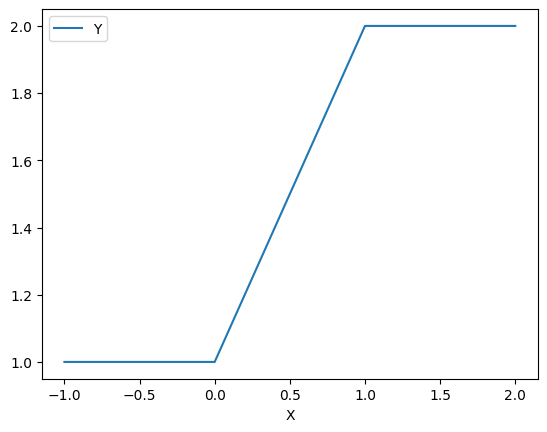

In [10]:
import pandas as pd
df = pd.DataFrame(data={'X':[0,1,-1,2],'Y':[1,2,1,2]},index=[0,1,2,3])
df = df.sort_values(by='X')
df.reset_index(drop=True,inplace=True)
df.plot(x='X',y='Y')
df

In [12]:

def Solar_Declination(DOY):
  gamma = 2*np.pi/365*(DOY-1)
  delta = 0.006918 - 0.399912 * np.cos(gamma)+0.070257 *np.sin(gamma)-0.006758 *np.cos(2*gamma) + 0.000907*np.sin(2*gamma)-0.002697*np.cos(3*gamma)+0.00148 *np.sin(3*gamma)
  declination=delta*180/np.pi
  return(declination)

Dates = pd.date_range('2024-01-01','2024-12-31')
Dates = pd.date_range('2024-06-21','2024-06-22')
Declination = Solar_Declination(Dates.dayofyear)
Declination
# plt.figure()
# plt.plot(Dates,Declination)
# plt.ylabel('Solar Declination')

Index([23.175556231549727, 23.234160110071496], dtype='float64')

In [254]:
# from tzfpy import get_tz
# import pytz
# tzinfo = pytz.timezone(get_tz(-123.256,49.265))


from tzfpy import get_tz
from datetime import *
import pandas as pd
import pytz
import numpy as np

class Tzfuncs():
    # Takes an input timezone or auto-determines a (DST aware) timezone from lat/lon coordinates
    # Will convert to TZ aware "UTC_time" and "Local_Time" along with non-TZ aware / non DST "Standard_Time"

    def __init__(self,Time_Zone=None,lat_lon=None,DST=False):
        self.DST = DST
        self.lat_lon = lat_lon
        if Time_Zone is not None:
            self.Time_Zone = pytz.timezone(Time_Zone)
        elif self.lat_lon is not None:
            self.AssumeTZ(lat_lon[1],lat_lon[0])
        else:
            print(f'No Time Zone Info Provided')

    def AssumeTZ(self,lon,lat):
        self.DST=True
        print(f'Timezone not provided, estimating for {lon}, {lat}')
        self.Time_Zone = pytz.timezone(get_tz(lon,lat))

    def convert(self,Input_Time,from_UTC=False,to_UTC=False):
        if isinstance(Input_Time,pd.DatetimeIndex):
            Input_Time=Input_Time.to_series()
        if from_UTC == False:
            self.Local_Time=Input_Time
            self.to_StandardTime(to_UTC)
            if self.lat_lon is not None:
                self.get_LAT()
        else:
            self.UTC_Time=Input_Time
            self.fromUTC()

    def to_StandardTime(self,to_UTC=False):
        offset = self.Local_Time.apply(lambda x: self.Time_Zone.dst(x,is_dst=self.DST))
        if self.DST == True:
            self.Standard_Time = pd.DatetimeIndex(self.Local_Time-offset)
            self.Local_Time = self.Local_Time.apply(lambda x: self.Time_Zone.localize(x,is_dst=self.DST))
        else:
            self.Standard_Time = pd.DatetimeIndex(self.Local_Time)
            self.Local_Time = (self.Local_Time+offset).apply(lambda x: self.Time_Zone.localize(x,is_dst=self.DST))
        if to_UTC == True:
            self.toUTC()
        self.Local_Time = pd.DatetimeIndex(self.Local_Time)

    def toUTC(self):
        self.UTC_Time = pd.DatetimeIndex(self.Local_Time.apply(lambda x: x.astimezone(pytz.utc)))

    def fromUTC(self):
        self.UTC_Time = self.UTC_Time.apply(lambda x: pytz.utc.localize(x, is_dst=self.DST))
        self.Local_Time = self.UTC_Time.apply(lambda x: x.astimezone(self.Time_Zone).replace(tzinfo=None))
        self.to_StandardTime(to_UTC=False)
        self.UTC_Time = pd.DatetimeIndex(self.UTC_Time)
    
    def get_LAT(self):
        Meridian = pd.Series([15*t.utcoffset().total_seconds()/3600 for t in self.Local_Time])
        self.LST = self.Local_Time.hour*60+self.Local_Time.minute
        self.LMST = self.LST+(self.lat_lon[1]-Meridian)*4
        max_DOY = (self.Local_Time+pd.offsets.YearEnd()).dayofyear
        gamma = 2*np.pi/max_DOY*(self.Local_Time.dayofyear-1+(self.Local_Time.hour-12)/24)
        self.Delta_LAT = 229.18*(0.000075+0.001868*np.cos(gamma)-0.032077*np.sin(gamma)-0.014615*np.cos(2*gamma)-0.040849*np.sin(2*gamma))
        self.LAT = self.LMST-self.Delta_LAT

tz = Tzfuncs(lat_lon=[50,-127.5])
Dates = pd.date_range('2024-07-22 8:00','2024-07-22 9:00')
print()
tz.convert(Dates)
print(f'{int(np.floor(tz.LAT[0]/60))}:{int(tz.LAT[0]/60%1*60)}')

Timezone not provided, estimating for -127.5, 50

6:36


In [253]:
(Dates+ pd.offsets.YearEnd()).dayofyear 
# Dates

Index([366], dtype='int32')

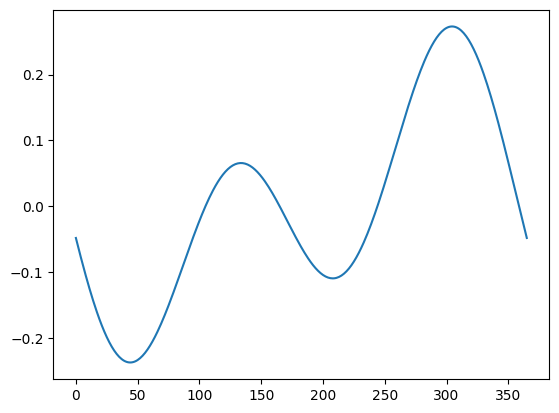

In [233]:
import matplotlib.pyplot as plt
Dates = pd.date_range('2024-01-01 12:00','2024-12-31 12:00')
tz.convert(Dates)
# tz.LAT

plt.figure()
plt.plot(tz.Delta_LAT/60)
# plt.plot(tz.LAT_alt/60)
# tz.LMST

In [272]:
import pandas as pd
import numpy as np
import datetime
from IPython.display import Markdown
from tabulate import tabulate
Mon = pd.date_range("20240108", "20240412", freq='W-Mon')
Wed = pd.date_range("20240108", "20240424", freq='W-Wed')
Week = np.arange(1,Mon.shape[0])
Lecture_Dates = Mon.union(Wed).date

Lectures = pd.DataFrame(data={'Date':Lecture_Dates})
Lectures['Topic']=''
Lectures['Suggested Reading']=''
Lectures['Study Questions']=''
Topics = [
'Course Overview',
'What is Micrometeorology?',
'Energy and Mass Balances',
'**Snow Day**/No Class',
'A Deeper Dive into Surface Energy Balances',
'Radiation Geometry'
]
Readings = [
    '',
    'Open Geomatics section [3.1](https://www.opengeomatics.ca/types-of-data.html#types-of-phenomena) & [3.2](https://www.opengeomatics.ca/types-of-data.html#types-of-data-1)',
    '',
    '',
    '',
    '[Additional Reading](../www/readings04_05.pdf)'
]
Study = ['',
        '',
        '[01](../Study_Questions/01.html)',
        '',
        '',
        '[02](../Study_Questions/02.html)',
        ]

for i,row in Lectures.iterrows():
    if i <= len(Topics)-1:
        Lectures.loc[Lectures.index==i,'Topic'] = Topics[i]
    if i <= len(Readings)-1:
        Lectures.loc[Lectures.index==i,'Suggested Reading'] = Readings[i]
    if i <= len(Study)-1:
        Lectures.loc[Lectures.index==i,'Study Questions'] = Study[i]

Lectures.set_index('Date',inplace=True)

Lectures.loc[Lectures.index==pd.to_datetime('2024-03-13').date(),'Topic'] #= '**Midterm Exam**'
# Lectures.loc[Lectures.index==pd.to_datetime('2024-04-24'),'Topic'] = '**Final Exam**'
# Lectures.index[10]
# pd.to_datetime('2024-03-13').date()

Date
2024-03-13    
Name: Topic, dtype: object

In [26]:
import numpy as np

class LW_calcs():
  def __init__(self,T_a,RH):
    self.T_a=T_a
    if RH>1:
      self.RH=RH*.01
    else:
      self.RH=RH
    self.T_ak = T_a+273.15
    self.Prata()

  def Prata(self):
    self.Pv_from_RH()
    a = 1.2
    b = 3
    zeta = 46.5*(self.P_v/self.T_ak)
    self.epsilon_a = 1-(1+zeta)*np.exp(-(a+b*zeta)**0.5)

  def Pv_from_RH(self):
    P_v_star = 6.112*np.exp(17.62*self.T_a/(243.12+self.T_a))
    self.P_v = self.RH*P_v_star
LW = LW_calcs(9,80)
LW.epsilon_a

0.7709475025549156

In [34]:
import pandas as pd


# Import the data from github & parse the timestamp for each record
data_url='https://raw.githubusercontent.com/GEOS300/AssignmentData/main/Climate_Summary_BB.csv'
# Pandas (pd here) allows us to set a timestamp as an index which lets us easily parse time series data
df = pd.read_csv(data_url,parse_dates=['TIMESTAMP'],index_col=['TIMESTAMP'])
# Using this we can get a extra variables (DOY & HOUR) that will be helpful later
# df['HOUR'] = df.index.hour
# df['DOY'] = df.index.dayofyear

# # Preview the table using .head()
# df.head()

su = df.loc[((df.index.year==2023)&(df.index.month==8)&(df.index.day==21))]
# df.to_csv('../Lectures/Data/WxSolstice.csv')

<Axes: title={'center': 'August 21st, 2023'}, xlabel='Hour'>

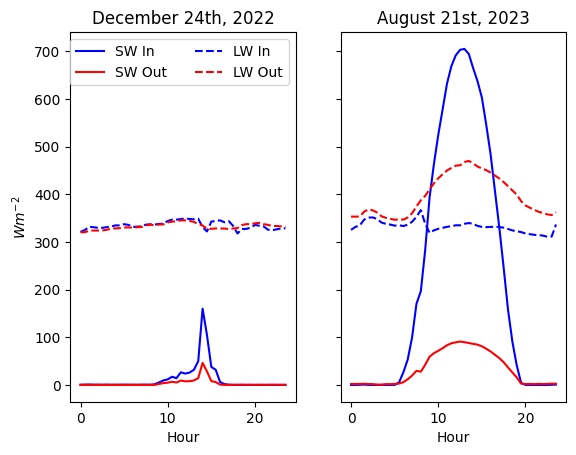

In [94]:
import matplotlib.pyplot as plt
import pandas as pd

# Import the data from github & parse the timestamp for each record
data_url='https://raw.githubusercontent.com/GEOS300/AssignmentData/main/Climate_Summary_BB.csv'
# Pandas (pd here) allows us to set a timestamp as an index which lets us easily parse time series data
df = pd.read_csv(data_url,parse_dates=['TIMESTAMP'],index_col=['TIMESTAMP'])
fig,ax=plt.subplots(1,2,sharey=True,sharex=True)
# fig.autofmt_xdate(rotation=45)
df['Hour'] = df.index.hour+df.index.minute/60
wx = df.loc[((df.index.year==2022)&(df.index.month==12)&(df.index.day==24))]
su = df.loc[((df.index.year==2023)&(df.index.month==8)&(df.index.day==21))]
wx.plot(ax=ax[0],x='Hour',y=['SW_IN_1_1_1','SW_OUT_1_1_1','LW_IN_1_1_1','LW_OUT_1_1_1'],
              color=['blue','red','blue','red'],
              style=['-','-','--','--'])
ax[0].set_title('December 24th, 2022')
ax[0].legend(['SW In','SW Out','LW In','LW Out'],ncol=2)
ax[0].set_ylabel('$W m^{-2}$')
        
ax[1].set_title('August 21st, 2023')
su.plot(ax=ax[1],x='Hour',y=['SW_IN_1_1_1','SW_OUT_1_1_1','LW_IN_1_1_1','LW_OUT_1_1_1'],
              color=['blue','red','blue','red'],
              style=['-','-','--','--'],legend=False)


Text(0, 0.5, '$MJ m^{-2} d^{-1}$')

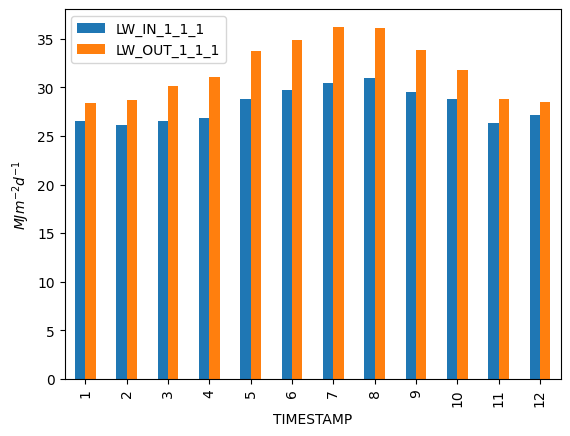

In [93]:
Monthly = df.loc[df.index.year<=2024].resample('M').mean()[['LW_IN_1_1_1','LW_OUT_1_1_1']]

Monthly = Monthly.groupby(Monthly.index.month).mean()*3600*24*1e-6
fig,ax=plt.subplots()
Monthly.plot(kind='bar',y=['LW_IN_1_1_1','LW_OUT_1_1_1'],ax=ax)
ax.set_ylabel('$MJ m^{-2} d^{-1}$')

In [103]:
import numpy as np

class get_epsilon_a():
  def __init__(self,T_a,RH):
    if T_a < 100:
      self.T_a = T_a
      self.T_ak = T_a+273.15
    else:
      self.T_ak=T_a
      self.T_a=T_a-273.15
    if RH>1:
      self.RH=RH*.01
    else:
      self.RH=RH
    self.Prata()

  def Prata(self):
    self.Pv_from_RH()
    a = 1.2
    b = 3
    zeta = 46.5*(self.P_v/self.T_ak)
    self.epsilon_a = 1-(1+zeta)*np.exp(-(a+b*zeta)**0.5)

  def Pv_from_RH(self):
    P_v_star = 6.112*np.exp(17.62*self.T_a/(243.12+self.T_a))
    self.P_v = self.RH*P_v_star
e = get_epsilon_a(9,80)

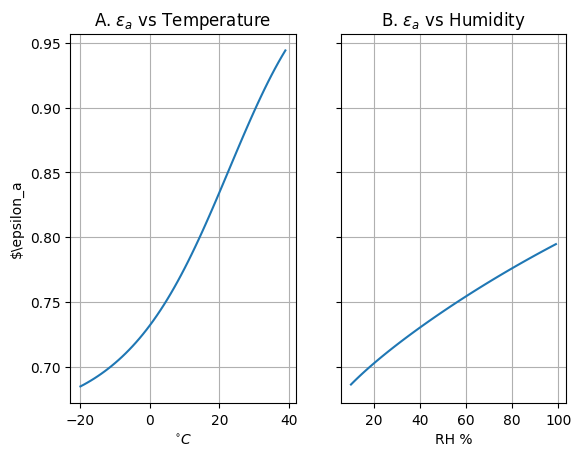

In [121]:
fig,ax=plt.subplots(1,2,sharey=True)
RH=np.arange(10,100)
TA=np.arange(-20,40)
RH_e = np.array([get_epsilon_a(10,rh).epsilon_a for rh in RH]) 
TA_e = np.array([get_epsilon_a(ta,80).epsilon_a for ta in TA]) 
ax[0].plot(TA,TA_e)
ax[0].set_title('A. $\epsilon_a$ vs Temperature')
ax[0].set_xlabel('$^{\circ} C$')
ax[0].set_ylabel('$\epsilon_a')
ax[0].grid()
ax[1].plot(RH,RH_e)
ax[1].set_title('B. $\epsilon_a$ vs Humidity')
ax[1].set_xlabel('RH %')
ax[1].grid()

In [26]:
Ca = 1210 # J m-3 K-1

z1 = 1 #m.a.g.l
z2 = 100 #m.a.g.l
Delta_z = z2-z1

Rn_z1 = 150 #Wm-2
Rn_z2 = 151 #Wm-2

t1 = 12 # 12:00 P.M.
t2 = 12.5 # 12:30 P.M.
Delta_t = (t2-t1)*3600 # Convert to seconds: 1 W = 1 J s-1

Delta_Rn = Rn_z2 - Rn_z1
Delta_Ta = Delta_Rn/(Ca*Delta_z)*Delta_t
Delta_Ta



0.015026296018031555

In [27]:
Ca = 1210 # J m-3 K-1

z1 = 1 #m.a.g.l
z2 = 12000 #m.a.g.l
Delta_z = z2-z1

Rn_z1 = -70 #Wm-2
Rn_z2 = -340 #Wm-2

t1 = 22 # 10:00 P.M.
t2 = 23 # 11:00 P.M.
Delta_t = (t2-t1)*3600 # Convert to seconds: 1 W = 1 J s-1

Delta_Rn = Rn_z2 - Rn_z1
print(Delta_Rn/Ca*Delta_t/Delta_z)


-0.06694772773764206


In [33]:
import numpy as np
Ca = 1210 # J m-3 K-1

z1 = 1 #m.a.g.l
z2 = 17000 #m.a.g.l
Delta_z = z2-z1

Rn_z1 = 125 #Wm-2
Rn_z2 = -100 #Wm-2

t1 = 0 # 12:00 A.M. (midnight)
t2 = 24 # 12:00 A.M. (midnight *the next day*)
Delta_t = (t2-t1)*3600 # Convert to seconds: 1 W = 1 J s-1

Delta_Rn = Rn_z2 - Rn_z1
Delta_Ta = Delta_Rn/(Ca*Delta_z)*Delta_t

print(f"The net temperature change attributable to radiative cooling is {np.round(Delta_Ta,2)} K")

The net temperature change attributable to radiative cooling is -0.95 K


In [14]:
Ca = 1210 # J m-3 K-1

z1 = 10 #m.a.g.l
z2 = 100 #m.a.g.l
Delta_z = z2-z1

Rn_z1 = -10 #Wm-2
Rn_z2 = -20 #Wm-2

t1 = 12 # 12:00 P.M.
t2 = 12.5 # 12:30 P.M.
Delta_t = (t2-t1)*3600 # Convert to seconds: 1 W = 1 J s-1

Delta_Rn = Rn_z2 - Rn_z1
print(Delta_Rn/Ca*Delta_t/Delta_z)




-0.1652892561983471


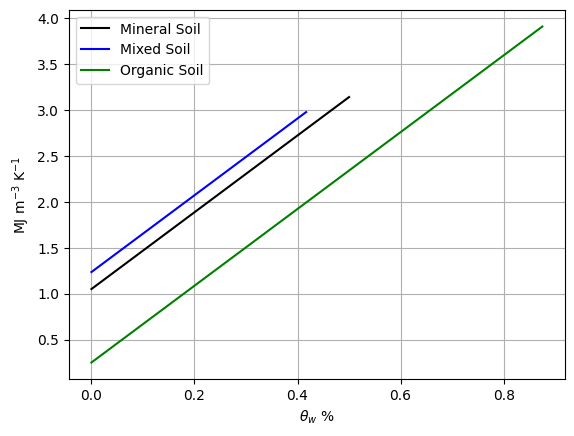

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def get_C(theta_m,theta_o,theta_w):
    C_w,C_m,C_o,C_a = 4.18, 2.1,2.5,0.0012 # MJ m-3 K-1
    theta_a = 1-(theta_m+theta_o+theta_w)
    theta_a[np.where(theta_a<0)]=np.nan # What does this line do?
    C = C_m*theta_m + C_o*theta_o + C_w*theta_w + C_a*theta_a
    return(C)

theta_w = np.linspace(0,1,25)
plt.figure()
plt.plot(theta_w,get_C(.5,0,theta_w),color='black',label='Mineral Soil')
plt.plot(theta_w,get_C(.35,.2,theta_w),color='blue',label='Mixed Soil')
plt.plot(theta_w,get_C(0,.1,theta_w),color='green',label='Organic Soil')
plt.ylabel(r'MJ m$^{-3}$ K$^{-1}$')
plt.xlabel(r'$\theta_w$ %')
plt.grid()
plt.legend()

In [24]:
C_s_g = 2 #MJ m-3 K-1
T_s_1 = 10 # C
T_s_2 = 11 # C
t1 = 12 # 12:00 P.M.
t2 = 13 # 1:00 P.M.

Delta_T = T_s_2 - T_s_1 # C (also K)
Delta_t = (t2 - t1)*3600 # S

H_g_z = C_s_g*Delta_T/Delta_t * 1e6
H_g_z # W m-1



277.77777777777777

Text(0, 0.5, '$W m^{-1} K|^{-1}$')

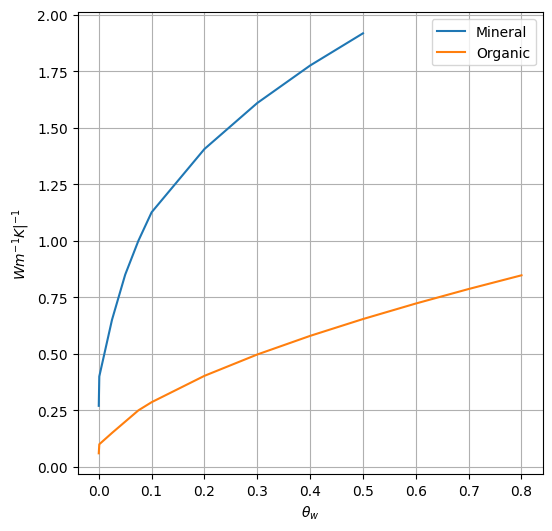

In [83]:
import pandas as pd 
df = pd.read_csv('../_Test/Data/Conductivity.csv')
df = df.set_index('theta_w')
fig,ax=plt.subplots(figsize=(6,6))
df[['Mineral','Organic']].plot(ax=ax)
ax.grid()
ax.set_xlabel(r'$\theta_w$')
ax.set_ylabel(r'$W m^{-1} K|^{-1}$')



# df = pd.read_csv('../_Test/Data/Diffusivity.csv')
# df = df.set_index('theta_w')
# fig,ax=plt.subplots(figsize=(6,6))
# df[['Mineral Firm','Mineral Loose','Organic']].plot(ax=ax)
# ax.grid()
# ax.set_xlabel(r'$\theta_w$')
# ax.set_ylabel(r'$m^2 s^{-1}$')


[0.510572   0.93698397]


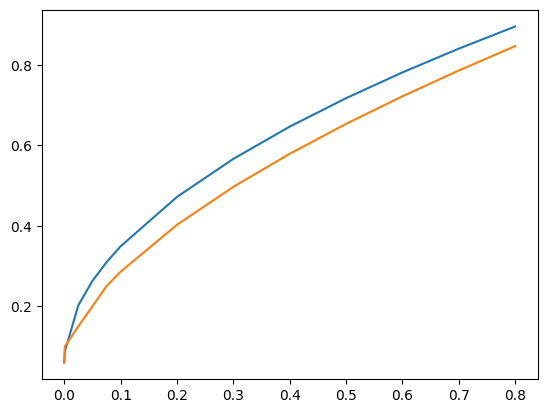

In [84]:

from scipy.optimize import curve_fit

def func(x, a, b):

    return x ** a * b + np.min(x)

df2 = df[['Mineral']].dropna()
popt, pcov = curve_fit(func, df.index, df['Organic'])
popt

fig,ax=plt.subplots()
ax.plot(df.index,df.index**popt[0]*popt[1]+df['Organic'].min())
# ax.plot(df2.index,df2.index**.5+popt[1])
ax.plot(df.index,df.Organic)

print(popt)


# mineral = [0.3282811, 2.38478456]
# organic = [0.510572, 0.93698397]

Text(0, 0.5, '$W m^{-1} K|^{-1}$')

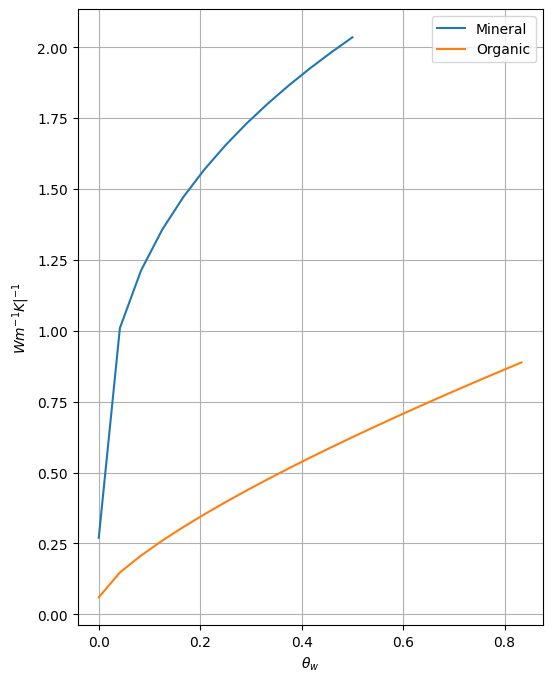

In [108]:

theta_w = np.linspace(0,1,25)

k_mineral = theta_w**0.35* 2.25 + 0.27
k_organic = theta_w**0.75* .95 + 0.06


k_mineral[np.where(theta_w>.5)]=np.nan
k_organic[np.where(theta_w>.85)]=np.nan

fig,ax=plt.subplots(figsize=(6,8))
ax.plot(theta_w,k_mineral,label='Mineral')
ax.plot(theta_w,k_organic,label='Organic')
ax.grid()
ax.legend()
ax.set_xlabel(r'$\theta_w$')
ax.set_ylabel(r'$W m^{-1} K|^{-1}$')

Text(0, 0.5, '$m^2 s^{-1}$')

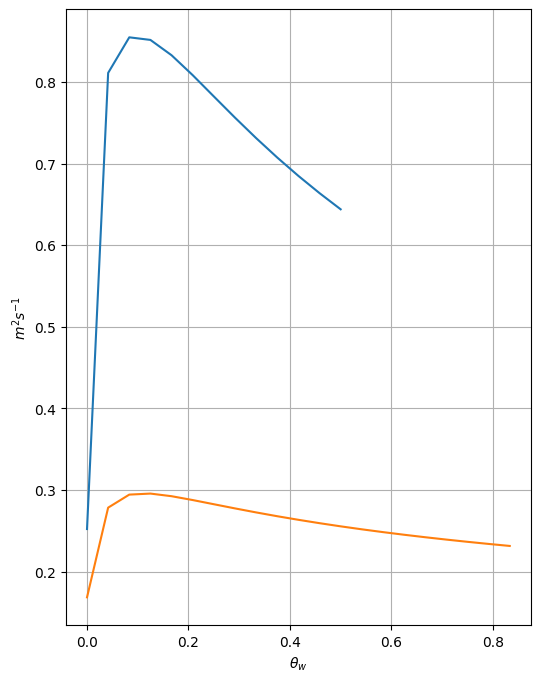

In [109]:

k_mineral[np.where(theta_w>.5)]=np.nan
k_organic[np.where(theta_w>.85)]=np.nan

fig,ax=plt.subplots(figsize=(6,8))
ax.plot(theta_w,k_mineral/get_C(.45,0.05,theta_w),label='Mineral')
ax.plot(theta_w,k_organic/get_C(0.05,.1,theta_w),label='Organic')


ax.grid()
ax.set_xlabel(r'$\theta_w$')
ax.set_ylabel(r'$m^2 s^{-1}$')

In [32]:
# import pandas as pd
import os
out = 'C:\\Users\\User\\Teaching\\GEOS300\\AssignmentData\\WesthamIslandSoilData/'
L = []
for file in os.listdir(out):
    if file.endswith('.txt'):
        L.append(file)
tbl = '''
Last digit of student number | date (YYYMMDD)
-----------------------------|-----\n'''
for i,l in enumerate(L[-11:-1]):
    tbl+=f'{str(i)}|{l.split(".")[0]}\n'
print(tbl)
# for file in os.listdir('../../2023_Assignments/GEOS300/assignment2/data/'):

#         df = pd.read_csv('../../2023_Assignments/GEOS300/assignment2/data/'+file,skiprows=12)
#         cols = [c.replace('"','').replace(' ','') for c in df.columns]
#         df.columns=cols
#         df = df.rename(columns={'QG':'H_g','Q*':'R_n','QG.1':'H'})
#         df['H'] = pd.to_numeric(df['H'],errors='coerce')
#         df['H'] = df['H'].fillna('-9999')
#         df[df.columns[~df.columns.str.contains('Unnamed')]].to_csv(out+file.split('data')[-1],index=False)


Last digit of student number | date (YYYMMDD)
-----------------------------|-----
0|20090614
1|20090630
2|20090701
3|20090702
4|20090711
5|20090716
6|20090721
7|20090729
8|20090730
9|20090802



In [2]:
import pandas as pd
import matplotlib.pyplot as plt
# Import the data from github & parse the timestamp for each record
data_url='https://raw.githubusercontent.com/GEOS300/AssignmentData/main/WesthamIslandSoilData/20090324.txt'
# Pandas (pd here) allows us to set a timestamp as an index which lets us easily parse time series data
df = pd.read_csv(data_url,parse_dates=['TIME(PST)'],index_col=['TIME(PST)'],na_values=-9999)

# Use linear interpolation to estimate missing H values where available
df['H_filled'] = df['H'].interpolate()
# Backfill where linear interpolation didn't work (the first observation)
df['H_filled'] = df['H_filled'].bfill()

df.head()


,T_1,T_2,T_3,T_4,H_g,WVC,R_n,H,H_filled
TIME(PST),,,,,,,,,
2009-03-24 00:15:00,0.844,1.110,1.383,1.313,-1.88,0.366,-1.2,NaN,-40.7
2009-03-24 00:30:00,0.822,1.112,1.372,1.307,-1.86,0.367,-1.5,-40.7,-40.7
2009-03-24 00:45:00,0.817,1.089,1.358,1.316,-1.89,0.367,-2.1,NaN,-28.5
2009-03-24 01:00:00,0.797,1.093,1.381,1.330,-1.98,0.367,-2.1,-16.3,-16.3
2009-03-24 01:15:00,0.788,1.060,1.382,1.333,-2.12,0.368,-1.8,NaN,-6.2


In [14]:
# plt.figure()
T_1 = df.iloc[48][['T_1','T_2']].mean()

T_2 = df.iloc[51][['T_1','T_2']].mean()

Delta_T_delta_t = (T_2-T_1)/3600

H_g = df.iloc[48:52]['H_g'].mean()
C = H_g/0.05/Delta_T_delta_t*1e-6
C

2.2962334217506624

In [24]:
df.loc[((df.index.hour<6)|((df.index.hour|6))),'H_g'].sum()*900

410301.0

In [11]:
df.iloc[12*4+1][['T_1','T_2','H_g']]

# 16.770 = -k*(1.981-4.183)/(10-5)

k = -(.10-.05)/(1.981-4.183)*16.770
k
# df.iloc[12*4+1]

0.38079019073569487

In [20]:
df.iloc[12*4:13*4][['T_1','T_2','H_g']].mean()

# 16.770 = -k*(1.981-4.183)/(10-5)

# k = -(.10-.05)/(1.981-4.183)*16.770

T_1 = (4.18+1.98)/2
T_2 = (4.837+2.458)/2

Delta_T=(T_2-T_1)/3600
C_s = 18.03500/.05/Delta_T * 1e-6
C_s

2.288140969162996

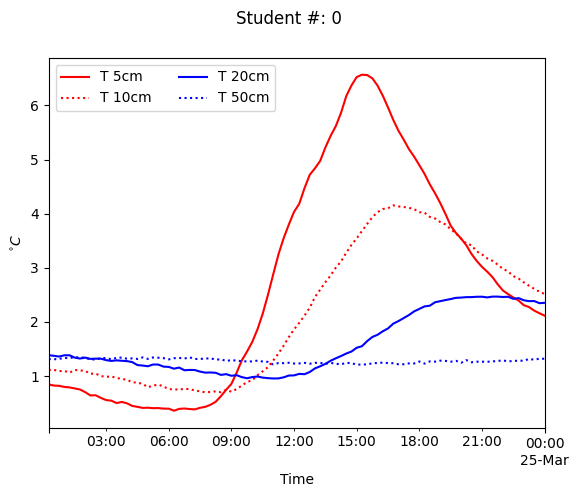

In [3]:
Student_Number = 00000000
fig,ax=plt.subplots()
plt.suptitle(f'Student #: {Student_Number}')
df[['T_1','T_2','T_3','T_4']].plot(ax=ax,
              color=['red','red','blue','blue'],
              style=['-',':','-',':'])
ax.set_ylabel(r'$^{\circ} C$')
ax.set_xlabel('Time')
ax.legend(['T 5cm','T 10cm','T 20cm','T 50cm',],ncol=2)

Text(0.5, 0, 'Time')

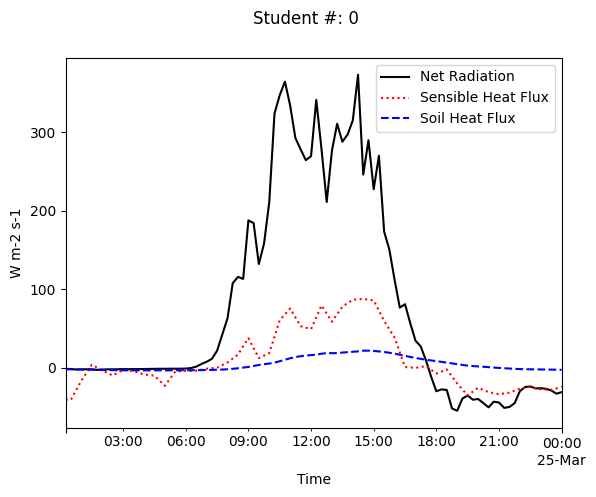

In [4]:
Student_Number = 00000000
fig,ax=plt.subplots()
plt.suptitle(f'Student #: {Student_Number}')
df[['R_n','H_filled','H_g']].plot(ax=ax,
              color=['black','red','blue'],
              style=['-',':','--'])
ax.legend(['Net Radiation','Sensible Heat Flux','Soil Heat Flux'])
ax.set_ylabel('W m-2 s-1')
ax.set_xlabel('Time')

Text(0.5, 1.0, 'Visible Light in Liquid Water')

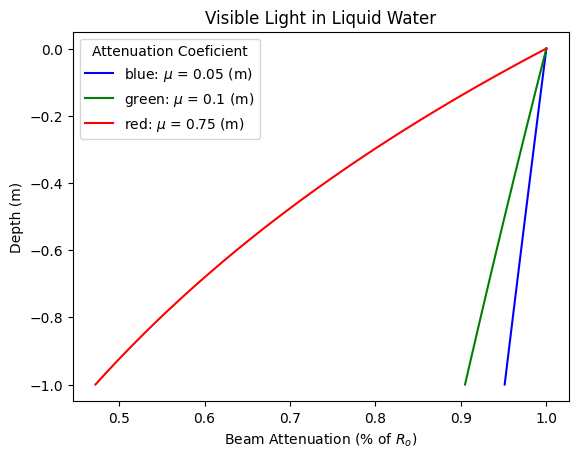

In [49]:
import numpy as np
def Beers_Law (R_0,X,mu):
    R_x = R_0*np.exp(-mu*X)
    return(R_x)

z = np.linspace(0,1)
R_0 = 1

fig,ax=plt.subplots()
for mu,c in zip([0.05,0.1,0.75],
            ['blue','green','red']):
    R_z = Beers_Law(R_0,z,mu)
    ax.plot(R_z,-z,color=c,
            label=f'{c}: $\mu$ = {mu} (m)')
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Beam Attenuation (% of $R_o$)')
ax.legend(title='Attenuation Coeficient')
ax.set_title('Visible Light in Liquid Water')

In [79]:
import pandas as pd
# import shutil
import os
import numpy as np
data_url='C:\\Users\\User\\Teaching\\GEOS300\\AssignmentData\\KettlemanCityCottonField/'
TimeStamp = '200008191630'
# W_max = []
# for f in os.listdir(data_url):
    # if 'wind' in f:
# Pandas (pd here) allows us to set a timestamp as an index which lets us easily parse time series data
# Turbulence = pd.read_csv(
# f'{data_url}wind{TimeStamp}.txt',skiprows=7,
#     parse_dates={'TIMESTAMP':['YYYY-MM-DD HH:MM:SS']},index_col='TIMESTAMP',na_values=-9999)
Wind = pd.read_csv(f'{data_url}wind{TimeStamp}.txt',skiprows=6,na_values=-9999)
# W_max.append(Wind['Horizontal wind velocity (m/s)'].max())
Wind
# W_max = np.array(W_max)
# print(W_max.max())

,Height (m),Horizontal wind velocity (m/s)
0,0.95,1.77
1,1.55,2.18
2,2.35,2.47
3,3.72,2.85
4,6.15,3.37
5,9.05,3.67


In [33]:
import os
import numpy as np
data_url='C:\\Users\\User\\Teaching\\GEOS300\\AssignmentData\\KettlemanCityCottonField/'
for f in os.listdir(data_url):
    if 'wind' in f:
        with open(data_url+f,'r') as file:
            lines = file.read()
            fbreak = lines.split('\n',7)
            fbreak.pop(6)
            # press = 101.325+np.round((np.random.rand(1)-.5)/2,3)[0]
            # fbreak.insert(5,f'# Air pressure: {press:.3f} kPa')
            txt = ('\n').join(fbreak).replace('Horizontal wind velocity (m/s)','Wind Speed (m/s)')
            print(txt)
        with open(data_url+f,'w') as file2:
            file2.writelines(txt)

# EBEX 2000, Kettleman City, CA, USA
# Wind profile measured by cup anemometers
# Start: 2000/08/02 15:30 PST
# Average values over 30 min
# Air temperature: 34.6 deg C
# Air pressure: 101.250 kPa

"Height (m)","Wind Speed (m/s)"
        0.95,         1.54
        1.55,         1.83
        2.35,         2.00
        3.72,         2.22
        6.15,         2.50
        9.05,         2.72

# EBEX 2000, Kettleman City, CA, USA
# Wind profile measured by cup anemometers
# Start: 2000/08/03 10:00 PST
# Average values over 30 min
# Air temperature: 29.0 deg C
# Air pressure: 101.460 kPa

"Height (m)","Wind Speed (m/s)"
        0.95,         1.19
        1.55,         1.42
        2.35,         1.57
        3.72,         1.76
        6.15,         2.00
        9.05,         2.13

# EBEX 2000, Kettleman City, CA, USA
# Wind profile measured by cup anemometers
# Start: 2000/08/03 10:30 PST
# Average values over 30 min
# Air temperature: 29.8 deg C
# Air pressure: 101.353 kPa

"Height (m)","Wi

1.1751196328367708 -2.0986472898421247
-2.0986472898421247


-0.05129329438755058

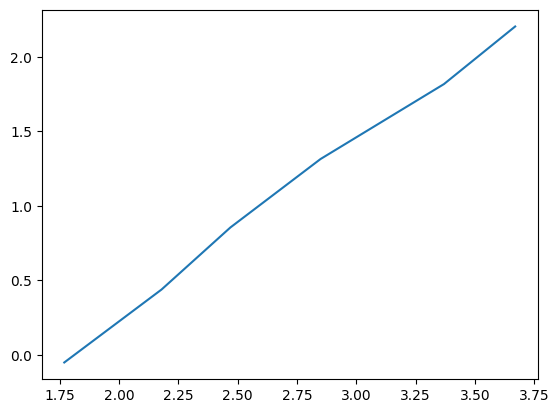

In [77]:
import matplotlib.pyplot as plt
import numpy as np

#y=mx+b > polyfit(x,y,1) will return the slope(m) and intercept(b) of a linear equation
m,b=np.polyfit(Wind['Horizontal wind velocity (m/s)'],np.log(Wind['Height (m)']),1)
print(m,b)
print(m*0+b)
fit,ax=plt.subplots()
ax.plot(Wind['Horizontal wind velocity (m/s)'],np.log(Wind['Height (m)']))

In [85]:
Wind=pd.concat([Wind,
    pd.DataFrame(data={
    'Horizontal wind velocity (m/s)':[0],
    'Height (m)':[1],#Height in m
    'lnz':[1]
    })], ignore_index = True)
Wind

,Height (m),Horizontal wind velocity (m/s),lnz
0,0.95,1.77,NaN
1,1.55,2.18,NaN
2,2.35,2.47,NaN
3,3.72,2.85,NaN
4,6.15,3.37,NaN
5,9.05,3.67,NaN
6,1.00,0.00,1.0


In [74]:
import numpy as np
Wind['lnz'] = np.log(Wind['Height (m)'])
Wind['U'] = Wind['Horizontal wind velocity (m/s)']
np.polyfit(Wind['U'],Wind['lnz'],1)
# np.polyf
# Wind

array([ 1.17511963, -2.09864729])

In [71]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(Wind[['Horizontal wind velocity (m/s)']],np.log(Wind['Height (m)']))
reg.coef_
reg.intercept_

-2.0986472898421247

In [12]:
dT_dt = 1.38e-4
C = 2e6
z0 = 0
z1 = 0.05
H1 = 25

dz = z1-z0

# DH = H1-H0
H0 = H1-dT_dt*C*dz
H0

11.2

In [34]:
# At 11:30 in the morning, we measure a soil heat flux density 
H_G5 = 25
H_G0 = 38.8
# Calculate the soil heat flux density at the surface H_G0
C = 2e6

T1 = 24.8
T2 = 25.3
t = 60*60

print((T2-T1)/t)

# Hg1=25
# Hg2=13
z1=0
z2=5e-2


B = H_G5
A = H_G0
b = z2
a = z1

(A-B)/(a-b)*-1/C

0.0001388888888888889


0.00013799999999999997

$\small\frac{\Delta T_s}{\Delta t} = \frac{1}{C}\frac{\Delta H_g}{\Delta z} = \frac{1}{C}\frac{H_{in}-H_{out}}{0-5}$

$-5 C\small\frac{\Delta T_s}{\Delta t} = H_{in}-H_{out}$

$H_{z0}+\Delta zC\small\frac{\Delta T_s}{\Delta t} = H_{z5}$



